# Effective Approaches to Attention-based Neural Machine Tranlation

L'objectif de ce travail consiste à explorer les résultats obtenus dans l'article [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) et de reproduire certain des ces résultats. 

Certaines parties de ce notebook sont basées sur le tutoriel [Neural machine translation with attention](https://www.tensorflow.org/tutorials/text/nmt_with_attention).


Ce notebook détail les implémentations des modèles utilisés pour la traduction de phrase d'anglais à français. Le dataset utilisé pour l'entraînement et l'évaluation de nos modèles provient du site http://www.manythings.org/anki/.


Travail présenté par : 

- Fabrice Charbonneau
- Antoine Daigneault-Demers
- Jérémie Huppé

## Détails d'implémentation

### Encodeur 
- Un *stack* de 2 couches LSTM de 1000 *units* avec dropout de 0.2 optionnel

### Attention 

Deux implémentations de méchanismes d'attention sont présentées dans ce notebook :

- Attention *globale* avec score *dot*
- Attention *local-p* avec score *general* et une taille de fenêtre D = 10

### Décodeur 
- Un *stack* de 2 couches LSTM de 1000 *units* avec dropout de 0.2 optionnel
- Avec ou sans un méchanisme d'attention pour la prédiction
- Utilisation du principe de *teacher forcing* lors de l'entraînement

### Paramètres d'entraînement

Voici les paramètres utilisés lors de l'entraînement des différents modèles :

- BATCH_SIZE = 128
- embedding_dim = 1000


In [0]:
REVERSE = False
DROPOUT = True
ATTENTION = False

## Implémentation 

In [0]:
import tensorflow as tf
import keras.backend as K

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import SmoothingFunction

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd
import nltk

Using TensorFlow backend.


In [0]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

## Dataset

Le dataset French - English fra-eng.zip (175623) de http://www.manythings.org/anki/ a été utilisé pour entrainer nos modèles.

Le preprocessing utilisé dans le tutoriel [Neural machine translation with attention](https://www.tensorflow.org/tutorials/text/nmt_with_attention) a été réutilisé pour ce travail.

Ce preprocessing consite à :

1. Ajouter un token *start* et un token *end* à chaque phrase.
2. Enlever les caractères spéciaux des phrases.
3. Créer un index des mots et un index inversé afin d'obtenir un dictionnaire mot → id et un autre dictionnaire id → mot.
4. Ajouter du remplissage pour que chaque phrase ait comme taille la taille de la plus grande phrase du dataset.

In [0]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import zipfile
root_folder = "drive/My Drive/INF8225_Project_Shared_Folder/"
path_to_zip = root_folder + "fra-eng.zip"

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(root_folder)

path_to_file = os.path.dirname(root_folder)+"/fra.txt"

In [0]:
def ouput_dataframe(df, csv_name):
    output_file_path = [PROJECT_PATH, csv_name]
    output_file = os.path.join('', *output_file_path)
    df.to_csv(output_file, sep=',', encoding='utf-8', index=False) 

In [0]:
# Preprocessing provenant du tutoriel Neural machine translation with attention 
# Lien : https://www.tensorflow.org/tutorials/text/nmt_with_attention

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w, reverse=False):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # Reverse the sentence's words
    if reverse:
        w = " ".join(w.split()[::-1])

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, FRENCH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = []
    for l in lines[:num_examples]:
        sentences = l.split('\t')
        #                                       Source (input)  (ENGLISH)               Target (output) (FRENCH) 
        word_pairs.append([preprocess_sentence(sentences[1], reverse=False), preprocess_sentence(sentences[0], reverse=False)])

    return zip(*word_pairs)

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)
    # Create language tokenizers and extract tensors
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Définir la taille du dataset lors de sa création 


In [0]:
# La taille du dataset a été fixée à num_examples :
num_examples = 60000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [0]:
# Création du training and validation sets en utilisant un split 80-20
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

48000 48000 12000 12000


In [0]:
def tensor_to_sentence(lang, tensor_value):
    output = []
    for index, value in enumerate(tensor_value): 
        if value != 0:
            output.append(lang.index_word[value])
    
    return output[1:-1]

In [0]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [0]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> i
41 ----> ll
27 ----> have
13 ----> to
98 ----> work
176 ----> hard
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> je
121 ----> vais
1081 ----> devoir
306 ----> travailler
387 ----> dur
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [0]:
# Les paramètres ci-dessous sont les paramètres utilisés dans l'article. 

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 1000
units = 1000
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 12]), TensorShape([128, 19]))

## Implémentation de l'architecture

### Encodeur

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.dropout = dropout
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        if DROPOUT:
            dropout_val = 0.2
        else: 
            dropout_val = 0

        self.lstm1 = tf.keras.layers.LSTM(self.enc_units,
                                          return_sequences=True,
                                          return_state=True,
                                          recurrent_initializer='glorot_uniform',
                                          dropout = dropout_val)

        self.lstm2 = tf.keras.layers.LSTM(self.enc_units,
                                          return_sequences=True,
                                          return_state=True,
                                          recurrent_initializer='glorot_uniform',
                                          dropout = dropout_val)


    def call(self, x, encoder_states):
        x = self.embedding(x)

        e_outputs, h1, c1 = self.lstm1(x, initial_state=encoder_states[0])

        whole_sequence_output, h2, c2 = self.lstm2(e_outputs, initial_state=encoder_states[1])

        encoder_states = [[h1, c1], [h2, c2]]

        return whole_sequence_output, encoder_states

    def initialize_hidden_state(self):
        return [[tf.zeros((self.batch_sz, self.enc_units)) for i in range(2)] for j in range(2)]

In [0]:
# Démo Encoder 

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, DROPOUT)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden_states = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder state shape: h2 : (batch size, units) {}'.format(sample_hidden_states[1][0].shape))
print ('Encoder state shape: c2 : (batch size, units) {}'.format(sample_hidden_states[1][1].shape))

Encoder output shape: (batch size, sequence length, units) (128, 12, 1000)
Encoder state shape: h2 : (batch size, units) (128, 1000)
Encoder state shape: c2 : (batch size, units) (128, 1000)


### Attention

In [0]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.W_p = tf.keras.layers.Dense(units)
        self.v_p = tf.keras.layers.Dense(1)
        self.W_a = tf.keras.layers.Dense(units)


    def non_zero_softmax_on_row(self, row_tensor): 
        # Inputs : 
        #   row_tensor shape : (max_length_sentence, 1)

        # Création d'une partition basée sur la condition non_zeros :
        non_zeros_bool = ~tf.equal(row_tensor, 0.)
        non_zeros_int = tf.cast(non_zeros_bool, tf.int32)
        partitioned_tensor = tf.dynamic_partition(row_tensor, non_zeros_int, 2)

        # Application du softmax seulement sur les valeurs non égales à 0.
        partitioned_tensor[1] = tf.nn.softmax(partitioned_tensor[1])

        # Trouver les indices à remplacer les résultats du softmax
        condition_indices = tf.dynamic_partition(tf.range(tf.size(row_tensor)), tf.reshape(non_zeros_int, [-1]), 2)

        # Effectuer le remplacement
        softmax_row_tensor = tf.dynamic_stitch(condition_indices, partitioned_tensor)
        softmax_row_tensor = tf.math.abs(softmax_row_tensor) # remove -0.0 values
        softmax_row_tensor = tf.reshape(softmax_row_tensor, tf.shape(row_tensor))

        return softmax_row_tensor

    def non_zero_softmax_on_matrix(self, matrix_tensor):
        return tf.map_fn(self.non_zero_softmax_on_row, matrix_tensor)

    def call(self, dec_hidden_last_layer, enc_output):
        # Inputs : 
        #   dec_hidden = ht du dernier layer  -> (batch_size, hidden_size)
        #   enc_output = all hs               -> (batch_size, max_len, hidden_size) 
        #   S est la longueur des phrases (longueur de la plus longue phrase)
        #   D est la taille de la fenetre (window)

        batch_size = enc_output.shape[0]
        S = enc_output.shape[1] 
        D = 10.0
        sigma = D / 2.0

        dec_hidden_last_layer_time_axis = tf.expand_dims(dec_hidden_last_layer, axis=1) # (batch_size, 1, hidden_size)   

        # Trouvons pt. pt = S * sig(vp * tanh(Wp ht))
        pt = self.W_p(dec_hidden_last_layer_time_axis)  
        pt = tf.keras.activations.tanh(pt)                      # (batch_size, 1, hidden_size)
        pt = self.v_p(pt)                                       # (batch_size, 1, 1)
        pt = tf.keras.activations.sigmoid(pt)                   # (batch_size, 1, 1)
        pt = pt * (S-1)                                         # (batch_size, 1, 1)   


        pt_copy = tf.identity(pt)                               # (batch_size, 1, 1)
        multiplies = tf.constant([1, S, 1], tf.int32)  
        pt_matrix = tf.tile(pt_copy, multiplies)                # (batch_size, max_sent_length, 1)

        # Obtenir une matrice de contenant les indices de chaque colonne dans chaque ligne
        row_indexes = [np.arange(S)]
        matrix_row_indexes = np.repeat(row_indexes, batch_size, axis=0)                 # (batch_size, max_sent_length, 1)
        matrix_row_indexes = np.expand_dims(matrix_row_indexes, axis=2)
        matrix_row_indexes = tf.convert_to_tensor(matrix_row_indexes, dtype=tf.float32)

        # Trouvons la matrice window_one_hot_matrix avec un 1 aux indices des mots qui doivent
        # être considérés pour le calcul de l'attention
        window_pt_diff = tf.math.subtract(matrix_row_indexes, pt)
        window_pt_abs = tf.math.abs(window_pt_diff)
        window_one_hot_matrix = tf.where(tf.less(window_pt_abs, D), 1.0, 0.0)           # (batch_size, max_sent_length, 1)

        # Obtenir poids de la gaussienne
        s_minus_pt = tf.math.subtract(matrix_row_indexes, pt_matrix)
        s_minus_pt_pow_2 = tf.map_fn(lambda x: x*x, s_minus_pt)
        num_divided_by_denum = tf.math.divide(s_minus_pt_pow_2, 2*(sigma**2))
        gaussian = tf.math.exp(-num_divided_by_denum)                                   # (batch_size, max_sent_length, 1)

        # Obtenir poids de la gaussienne seulement pour les mots faisant partie 
        # du calcul de l'attention
        gaussian_window = tf.math.multiply(gaussian, window_one_hot_matrix)             # (batch_size, max_sent_length, 1)

        # Calcul du score
        score = self.W_a(enc_output)    # score (Wa@hs) score.shape = (batch_size, max_sent_length, hidden_size)
        score = tf.keras.layers.Dot(axes=[2, 2])([score, dec_hidden_last_layer_time_axis])  # score ht.T Wa@hs score.shape = (batch_size, max_sent_length, 1)

        # Obtenir seulement les score faisant partie des mots à considérer
        # pour le calcul de l'attention
        score_one_hot = tf.math.multiply(window_one_hot_matrix, score)

        # Appliquer softmax seulement sur les éléments de chaque ligne non égal à 0.
        # Ces éléments représentent le score de chaque mot qui doit être considéré 
        # pour le calcul de l'attention
        align_ht_hs = self.non_zero_softmax_on_matrix(score_one_hot)

        # Obtenir les poids de l'attention en multipliant élément par élément 
        # les poids de la gaussienne au éléments de align_ht_hs
        attention_weights = tf.math.multiply(gaussian_window, align_ht_hs) # (batch_size, max_sent_length, 1)

        # Trouver ct = (batch_size, hidden_size) 
        # Détails : hs = (batch_size, max_sent_length, hidden_size) * at = (batch_size, max_sent_length, 1)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1) # (BATCH_SIZE, 1000)

        return context_vector, attention_weights

In [0]:
# Démo Attention Layer 

attention_layer = LuongAttention(units)

def get_dec_hidden_last_layer_time_axis():
    return tf.random.uniform((BATCH_SIZE, units), minval=0, maxval=1, dtype=tf.float32, seed=64)

dec_hidden_last_layer_time_axis = get_dec_hidden_last_layer_time_axis()
attention_result, attention_weights = attention_layer(dec_hidden_last_layer_time_axis, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1000)
Attention weights shape: (batch_size, sequence_length, 1) (128, 12, 1)


### Décodeur

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, dropout):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.dropout = dropout
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.W_c = tf.keras.layers.Dense(self.dec_units)

        if dropout:
            dropout_val = 0.2
        else: 
            dropout_val = 0

        self.lstm1 = tf.keras.layers.LSTM(self.dec_units,
                                          return_sequences=True,
                                          return_state=True,
                                          recurrent_initializer='glorot_uniform',
                                          dropout = dropout_val)

        self.lstm2 = tf.keras.layers.LSTM(self.dec_units,
                                          return_sequences=True,
                                          return_state=True,
                                          recurrent_initializer='glorot_uniform',
                                          dropout = dropout_val)

        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = LuongAttention(self.dec_units)


    def call(self, dec_input, dec_hidden, enc_output):
        # Inputs:
        #   dec_input shape == (batch_size, max_length, dec_hidden_size)
        #   dec_hidden shape == (batch_size, dec_hidden_size)
        #   enc_output shape == (batch_size, max_length, dec_hidden_size)

        # x après le layer de embeddings == (batch_size, 1, embedding_dim)
        x = self.embedding(dec_input)

        d_outputs, dh1, dc1 =  self.lstm1(x, initial_state=dec_hidden[0])
        d_outputs_final, dh2, dc2 = self.lstm2(d_outputs, initial_state=dec_hidden[1]) 

        decoder_states = [[dh1, dc1], [dh2, dc2]]

        if ATTENTION:
            # Évaluer ht_hat = tanh(Wc[concat(ct,ht)])

            # output shape == (batch_size * 1, hidden_size)
            output = tf.reshape(d_outputs_final, (-1, d_outputs_final.shape[2]))

            context_vector, attention_weights = self.attention(output, enc_output) 
            ct_ht = tf.concat([context_vector, output], axis=-1) # ct_ht shape == (batch_size, embedding_dim + dec_hidden_size)
            Wc_ct_ht = self.W_c(ct_ht)
            ht_hat =  tf.keras.activations.tanh(Wc_ct_ht)   # ht_hat shape == (batch_size, embedding_dim)

            # output shape == (batch_size, embedding_dim)
            output = ht_hat
        else: 
            attention_weights = None
            # output shape == (batch_size * 1, embedding_dim)
            output = tf.reshape(d_outputs_final, (-1, d_outputs_final.shape[2]))


        Ws_ht = self.fc(output) # Ws_ht shape == (batch_size, vocab)

        return Ws_ht, decoder_states, attention_weights

In [0]:
# Démo Decoder 

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, DROPOUT)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden_states, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 11190)


## Fonction de perte et optimiseur 

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Entraînement

1. Passez *l'entrée* à travers *l'encodeur* qui retourne *la sortie de l'encodeur* et *l'état caché de l'encodeur*.
2. La sortie de l'encoder, l'état caché de l'encodeur et l'entrée du décodeur (qui est le token *start*) sont transmis au décodeur.
3. 3. Le décodeur renvoie les prédictions et l'état caché du décodeur.
4. L'état caché du décodeur est ensuite passée une fois de plus dans le modèle et les prédicitions sont utilisées pour évaluer la loss.
5. Le principe de *teacher forcing* est utilisé pour déterminer le prochain entré du décodeur.
6. La dernière étape consiste à évaluer le gradient et l'appliquer à l'optimisateur pour ensuite procéder à la backpropagation.

In [0]:
# La boucle d'entraînment provient du tutoriel Neural machine translation with attention 
# et a été adapté pour notre architecture.
# Lien : https://www.tensorflow.org/tutorials/text/nmt_with_attention

@tf.function
def train_step(inp, target, enc_states):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_states = encoder(inp, enc_states)

        dec_hidden = enc_states

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, target.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(target[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, t], 1)

    batch_loss = (loss / int(target.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [0]:
EPOCHS = 20

col_names =  ['Epoch', 'Loss']
loss_df  = pd.DataFrame(columns = col_names)

for epoch in range(EPOCHS):
    start = time.time()

    enc_states = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_states)
        total_loss += batch_loss

    if batch % 100 == 0: 
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
 
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
           
    loss_df.loc[len(loss_df)] = [epoch + 1, K.eval(total_loss / steps_per_epoch)]

Epoch 1 Loss 1.5953
Time taken for 1 epoch 143.84101009368896 sec

Epoch 2 Loss 1.0333
Time taken for 1 epoch 112.0971736907959 sec

Epoch 3 Loss 0.8147
Time taken for 1 epoch 109.88107943534851 sec

Epoch 4 Loss 0.6581
Time taken for 1 epoch 112.11165642738342 sec

Epoch 5 Loss 0.5328
Time taken for 1 epoch 109.66650485992432 sec

Epoch 6 Loss 0.4286
Time taken for 1 epoch 112.80205583572388 sec

Epoch 7 Loss 0.3423
Time taken for 1 epoch 110.29715061187744 sec

Epoch 8 Loss 0.2726
Time taken for 1 epoch 112.55710554122925 sec

Epoch 9 Loss 0.2181
Time taken for 1 epoch 109.65402913093567 sec

Epoch 10 Loss 0.1767
Time taken for 1 epoch 110.79903197288513 sec

Epoch 11 Loss 0.1461
Time taken for 1 epoch 107.93765258789062 sec

Epoch 12 Loss 0.1232
Time taken for 1 epoch 110.89509606361389 sec

Epoch 13 Loss 0.1076
Time taken for 1 epoch 109.14932990074158 sec

Epoch 14 Loss 0.0962
Time taken for 1 epoch 112.06437683105469 sec

Epoch 15 Loss 0.0886
Time taken for 1 epoch 109.8610503673

In [0]:
if ATTENTION:
    csv_name = "tableau_loss_with_attention.csv"
    loss_df.to_csv(csv_name)
    !cp tableau_loss_with_attention.csv "drive/My Drive/"
else:  
    csv_name = "tableau_loss_without_attention.csv"    
    loss_df.to_csv(csv_name)
    !cp tableau_loss_without_attention.csv "drive/My Drive/"

## Traduction

* La fonction d'évaluation est similaire à la boucle d'entraînement, sauf que nous n'utilisons pas le *teacher forcing*. L'entrée du décodeur à chaque pas de temps t correspond à ses prédictions précédentes ainsi qu'à l'état caché et à la sortie de l'encodeur.
* La prédiction pour la traduction arrête lorsque le *end token* est atteint.
* Les *attention weights* sont enregistrés pour chaque instant t.


In [0]:
# Les fonctions utilisées pour la traduction proviennent du tutoriel Neural machine translation with attention 
# et ont été adaptées pour notre architecture et nos traitements.
# Lien : https://www.tensorflow.org/tutorials/text/nmt_with_attention

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence, REVERSE)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [[tf.zeros((1, units)) for i in range(2)] for j in range(2)]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        if attention_weights is None:
            attention_plot = None
        else:
            attention_weights = tf.reshape(attention_weights, (-1, ))
            attention_plot[t] = attention_weights.numpy()


        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence, print_attention=True):
    result, sentence, attention_plot = evaluate(sentence)

    if attention_plot is not None and print_attention:
        attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
        plot_attention(attention_plot, sentence.split(' '), result.split(' '))

    return result

## Restoration du dernier checkpoint pour tester

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
translate(u'I recovered')

'je m en suis remise . <end> '

In [0]:
translate(u'You re the oldest.')

'tu es le plus vieux . <end> '

In [0]:
translate(u'He walks to school .')

'il marche vers l ecole . <end> '

In [0]:
translate(u'Make a list .')

'faites une liste ! <end> '

In [0]:
translate(u'Is it your car .')

'c est votre voiture . <end> '

In [0]:
translate(u'He lied to me .')

'il m a menti . <end> '

In [0]:
translate(u'I didn t laugh .')

'je n ai pas ri . <end> '

In [0]:
translate(u'I work with him .')

'je travaille avec lui . <end> '

In [0]:
translate(u'I just moved here .')

'je viens de demenager ici . <end> '

In [0]:
translate(u'I felt left out .')

'je me suis senti delaisse . <end> '

In [0]:
translate(u'What did you make .')

'que vous avez fait . <end> '

In [0]:
translate(u'I want to be a student .')

'je veux etre fermier . <end> '

In [0]:
translate(u'I want to be a good student .')

'je veux etre une bonne etudiante . <end> '

In [0]:
translate(u'I want to be a bad student .')

'je veux etre une mauvaise personne . <end> '

## BLEU score sur test set

In [0]:
# input_tensor_val: phrase en entrée
# target_tensor_val : phrase attendue

smoother = SmoothingFunction()

BLEU_scores = {}

col_names =  ['Length', 'BLEUscore']
BLEU_df  = pd.DataFrame(columns = col_names)


col_names =  ['id', 'src', 'result', 'reference_str', 'sentence_length', 'BLEUscore']
sentence_sample_df  = pd.DataFrame(columns=col_names)


#for i in range(len(input_tensor_val)):
nb_examples = len(input_tensor_val)


for i in range(nb_examples):
    # On fait la traduction
    converted_sentence = tensor_to_sentence(inp_lang, input_tensor_val[i])
    sentence_length = str(len(converted_sentence))

    src = " ".join(converted_sentence)
    result = translate(src, print_attention=False).strip()
    hypothesis = result.split(" ")[:-1]
    reference = tensor_to_sentence(targ_lang, target_tensor_val[i])
    reference_str = " ".join(reference)


    # Il peut y avoir plusieurs références, mais pas dans notre cas
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, smoothing_function=smoother.method1)

    # Enregister certaines traductions pour une analyse manuelle
    percentage = 0.01
    if i % (int(percentage * nb_examples)) == 0:
        idx = i // (int(percentage * nb_examples))
        sentence_sample_df.loc[idx] = [idx, src, result, reference_str, sentence_length, BLEUscore] 

    if str(sentence_length) in BLEU_scores:
        occurences = BLEU_scores[sentence_length][0] + 1
        total = BLEU_scores[sentence_length][1] + BLEUscore
        BLEU_scores[sentence_length] = (occurences, total)
    else:
        BLEU_scores[sentence_length] = (1, BLEUscore)

lengths = []
BLEU_averages = []

for sentence_length, (occurences, total_BLEU_score) in BLEU_scores.items():
    length = int(sentence_length)
    average_BLEU_score = total_BLEU_score / occurences
    lengths.append(length)
    BLEU_averages.append(average_BLEU_score)
    BLEU_df.loc[len(BLEU_df)] = [length, average_BLEU_score] 

lists = sorted(zip(*[lengths, BLEU_averages]))
lengths, BLEU_averages = list(zip(*lists))

In [0]:
if ATTENTION:
    csv_name = "tableau_BLEU_with_attention.csv"
    #ouput_dataframe(BLEU_df, csv_name)
    BLEU_df.to_csv(csv_name)
    !cp tableau_BLEU_with_attention.csv "drive/My Drive/"

    csv_name = "tableau_traductions_with_attention.csv"
    #ouput_dataframe(sentence_sample_df, csv_name)
    sentence_sample_df.to_csv(csv_name)
    !cp tableau_traductions_with_attention.csv "drive/My Drive/"

else:
    csv_name = "tableau_BLEU_without_attention.csv"
    #ouput_dataframe(BLEU_df, csv_name)
    BLEU_df.to_csv(csv_name)
    !cp tableau_BLEU_without_attention.csv "drive/My Drive/"

    csv_name = "tableau_traductions_without_attention.csv"
    #ouput_dataframe(sentence_sample_df, csv_name)
    sentence_sample_df.to_csv(csv_name)
    !cp tableau_traductions_without_attention.csv "drive/My Drive/"


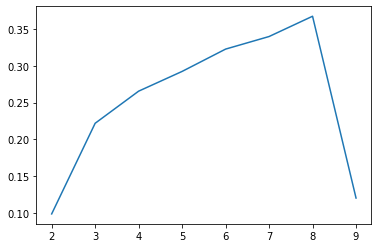

In [0]:
plt.plot(lengths, BLEU_averages)

In [0]:
global_BLEU_score = 0
global_occurences = 0

for sentence_length, (occurences, total_BLEU_score) in BLEU_scores.items():
    global_BLEU_score += total_BLEU_score
    global_occurences += occurences

print("Average BLEU score:", global_BLEU_score / global_occurences)

Average BLEU score: 0.30165615835180754
